# Simple Movie-Recommender

## Abstract

In this post, I will develop a very simple recommendation engine for movies based on regression. The goal is to show some basics of text ranking functionality. Even with a simple classifier as linear regression, we can produce some interesting results.

I will start with some theoretical background and will then show how the recommender can be implemented with Python.

## Methodology

In this post, I will follow the basic steps for an data analysis problem. Those are:

- Problem statement
- Analytic approach
- Data requirements
- Data collection / Dataset creation
- Data understanding / Exploratory Data Analysis
- Data preparation / Feature Engineering
- Modelling
- Evaluation
- Deployment
- Feedback

## Problem statement

The goal of this activity is to predict how much a user will like a new movie based on her previous ratings. We will use the following features of a movie:

- Title
- Genres
- Description
- Actors

Those features can be obtained from various sources. In this post I will work with artificial data to show the basic functionality of the recommender. Information about how to obtain and prepare data is out of scope for this post.

## Analytical approach

First, we need to understand and examine the problem to see what type of machine learning problem we have.  


### Supervised vs. unsupervised learning

The first decision is whether we face a problem in the area of *supervised* or *unsupervised* learning. 

*Unsupervised learning* means that we do not know how we shoud classify or structure the data. It is a way of findig a structure in the data without previous knowledge.

*Supervised learning* means that we know something about the data, e.g. we have examples and matching labels. The goal of supervised learning is then to find algorithms to predict the labels for new samples.

In this post we have some ranked movies as example, therefore we have a problem in the area of **supervised** learning.


### Classification vs. Regression

Supervised machine learning tasks can be separated into *classification* problems and *regression* problems. 

*Classification* sorts samples into discrete bins. Taking movies as example, a typical classification problem would be to predict the genre of a movie.

*Regression* predicts a continuous value for new samples. Taking movies as example, a typical regression problem would be to predict how much a user will like a new movie on a scale between 0 and 10.

In this post we want to predict the ranking of new movies, therefore we have a problem in the area of **regression**.

### Selecting the correct classifier

As stated above, we will use python to implement the recommender. One of the reasons to use python is the excellent availability of machine learning libraries. One of the most used packages is [scikit-learn](https://scikit-learn.org/stable/). This package provides a decision tree to select the matching classifier:

<img src="http://blog.yareblo.com/wp-content/uploads/2019/11/Estimator_Selection_Path-1.png" alt="Drawing" style="width: 600px;"/>

<div style="text-align: right">
[Source: scikit-learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
</div>

However, for the sake of simplicity I will use a linear regression classifier.


## Data requirements

To be able to complete our goal we need information about the movies and some already classified examples. For demonstational purposes, I will use the following features:

- Title
- Genres
- Description
- Actors

Of course, there are many more features which could be used, e.g. year, studio, directors, or ratings.

## Data collection / Dataset creation

As stated above, we will work with artificial data. This will help to demonstrate the basic concepts of the recommender. The following sections will show how to create a pandas dataframe with some data.

In [1]:
# Import pandas library 
import pandas as pd 
import numpy as np

# initialize columns
columns = ['Title', 'Genres', 'Description', 'Actors', 'Rating']

# initialize list of lists 
data = [['Superman', 'Action, Drama', 'Superhero superman beats the supervillian', 'Christopher Reeve, Dan Cooper', 8], 
        ['Batman', 'Action', 'Superhero batman is beating the joker', 'Ben Affleck, Dan Cooper', 6], 
        ['Spiderman', 'Action', 'Superhero spiderman will beat the vulture', 'Tobey Maguire, Dan Cooper', 7],
        ['Star Trek', 'Science Fiction', 'The space ship explores new worlds', 'Amy Campbell, Dan Cooper', 0],
        ['Antman', 'Action', 'Superhero beats the anteater', 'Christopher Reeve, Dan Cooper', np.nan],
        ['Star Wars', 'Science Fiction', 'The empire strikes back', 'Amy Campbell, John Doe', np.nan]] 
  
# Create the pandas DataFrame 
df_movies = pd.DataFrame(data, columns = columns) 
  
# print dataframe. 
df_movies

,Title,Genres,Description,Actors,Rating
0,Superman,"Action, Drama",Superhero superman beats the supervillian,"Christopher Reeve, Dan Cooper",8.0
1,Batman,Action,Superhero batman is beating the joker,"Ben Affleck, Dan Cooper",6.0
2,Spiderman,Action,Superhero spiderman will beat the vulture,"Tobey Maguire, Dan Cooper",7.0
3,Star Trek,Science Fiction,The space ship explores new worlds,"Amy Campbell, Dan Cooper",0.0
4,Antman,Action,Superhero beats the anteater,"Christopher Reeve, Dan Cooper",NaN
5,Star Wars,Science Fiction,The empire strikes back,"Amy Campbell, John Doe",NaN


## Data understanding / Exploratory Data Analysis

As I have created the data artificially specifically for my purpouse, we have already a good understanding of the data. Anyways, I will show some basic techniques for exploratory data analysis.

First, let's get an overview of the feature types:

In [2]:
df_movies.dtypes

Title           object
Genres          object
Description     object
Actors          object
Rating         float64
dtype: object

Let's note that 'Rating' is numerical, the other features are of type 'object'.

The "describe()"-Function provides another hint about the data. Since the result of this function is different for the type of feature, we need to perform two analysis:

In [3]:
# Analyse columns of type object
df_movies.select_dtypes(include=['object']).describe()

,Title,Genres,Description,Actors
count,6,6,6,6
unique,6,3,6,5
top,Star Trek,Action,Superhero beats the anteater,"Christopher Reeve, Dan Cooper"
freq,1,3,1,2


We see that we only have two unique types of genres. Let's see if we can learn more about this column.

In [4]:
df_movies['Genres'].value_counts()

Action             3
Science Fiction    2
Action, Drama      1
Name: Genres, dtype: int64

The next step is to analyse the rating column of type float:

In [5]:
# Analyse columns of type float
df_movies.select_dtypes(include=['float']).describe()

,Rating
count,4.000000
mean,5.250000
std,3.593976
min,0.000000
25%,4.500000
50%,6.500000
75%,7.250000
max,8.000000


Additionally, we want to have a visual representation of the distribution in the rating column:

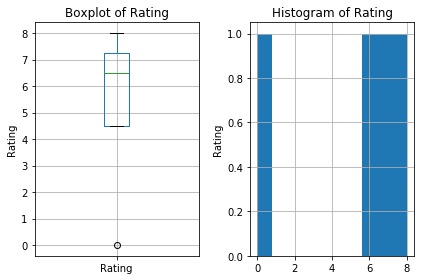

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1, 2, 1)
df_movies.boxplot(), plt.title('Boxplot of Rating'), plt.ylabel('Rating')

plt.subplot(1, 2, 2)
df_movies['Rating'].hist(bins=10), plt.title('Histogram of Rating'), plt.ylabel('Rating')
plt.tight_layout()

We can see that the most ratings are around the values 6-8 with one outlier with the value 0.

## Data preparation / Feature Engineering

The next step is to generate the features for the classifier. Since we have a numerical optimization problem of type regression, we need to convert the text to numerical features. 

There are various methods, but the most common ones are:

- one-hot encoding
- word count
- TF-IDF

But first we want to combine the features. 

### Converting actor and genres

Actor and genre names should be treated as complete words. Therefore, we need to replace the whitespace in actor names and genres with an underscore to avoid that these will be splitted.

Additionally, to avoid that a genre is mixed with a normal word in the movie description, we add a prefix to the genre.

In [7]:
# Split actors in list
df_movies['Actors_split1'] = df_movies['Actors'].str.split(",")
# replace spaces
df_movies['Actors_split2'] = df_movies.apply(lambda x: [w.strip().replace(' ', '_') for w in x['Actors_split1']], axis=1)
# merge list
df_movies['Actors_split3'] = df_movies.apply(lambda x: ", ".join(x['Actors_split2']) , axis=1)
# cleanup
df_movies['Actors'] = df_movies['Actors_split3']
df_movies.drop(['Actors_split1', 'Actors_split2', 'Actors_split3'], axis=1, inplace=True)
df_movies.head(2)

,Title,Genres,Description,Actors,Rating
0,Superman,"Action, Drama",Superhero superman beats the supervillian,"Christopher_Reeve, Dan_Cooper",8.0
1,Batman,Action,Superhero batman is beating the joker,"Ben_Affleck, Dan_Cooper",6.0


In [8]:
# Split genres in list
df_movies['Genres_split1'] = df_movies['Genres'].str.split(",")
# replace spaces and add prefix "genre"
df_movies['Genres_split2'] = df_movies.apply(lambda x: ["genre_"+w.strip().replace(' ', '_') for w in x['Genres_split1']], axis=1)
# merge list
df_movies['Genres_split3'] = df_movies.apply(lambda x: ", ".join(x['Genres_split2']) , axis=1)
# cleanup
df_movies['Genres'] = df_movies['Genres_split3']
df_movies.drop(['Genres_split1', 'Genres_split2', 'Genres_split3'], axis=1, inplace=True)
df_movies.head(2)

,Title,Genres,Description,Actors,Rating
0,Superman,"genre_Action, genre_Drama",Superhero superman beats the supervillian,"Christopher_Reeve, Dan_Cooper",8.0
1,Batman,genre_Action,Superhero batman is beating the joker,"Ben_Affleck, Dan_Cooper",6.0


Combine all columns except Rating into one feature-column

In [9]:
df_movies['Content'] = df_movies.loc[:, df_movies.columns != 'Rating'].apply(' '.join, axis=1)
df_movies.loc[0, 'Content']

'Superman genre_Action, genre_Drama Superhero superman beats the supervillian Christopher_Reeve, Dan_Cooper'

Now, we do some cleaning and removal of unwanted characters...

In [10]:
# do some cleaning and dimension reduction
df_movies['Content_Parsed_1'] = df_movies['Content'].str.replace("\r", " ")
df_movies['Content_Parsed_1'] = df_movies['Content_Parsed_1'].str.replace("\n", " ")
df_movies['Content_Parsed_1'] = df_movies['Content_Parsed_1'].str.replace("/", " ")
df_movies['Content_Parsed_1'] = df_movies['Content_Parsed_1'].str.replace('"', '')
df_movies['Content_Parsed_1'] = df_movies['Content_Parsed_1'].str.lower()

punctuation_signs = list("?:!.,;<>")
for punct_sign in punctuation_signs:
    df_movies['Content_Parsed_1'] = df_movies['Content_Parsed_1'].str.replace(punct_sign, ' ')


Additionally, we do some [lemmatizations](https://en.wikipedia.org/wiki/Lemmatisation) to reduce the variations of words in the features:

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('punkt')
wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(df_movies)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    text = df_movies.loc[row]['Content_Parsed_1']
    text_words = text.split(" ")
    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        # print(word," -> ", wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)
df_movies['Content_Parsed_2'] = lemmatized_text_list
pd.set_option('max_colwidth', 600)
df_movies['Content_Parsed_2'].head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]   Package punkt is already up-to-date!


0    superman genre_action  genre_drama superhero superman beat the supervillian christopher_reeve  dan_cooper
1                               batman genre_action superhero batman be beat the joker ben_affleck  dan_cooper
2                   spiderman genre_action superhero spiderman will beat the vulture tobey_maguire  dan_cooper
3                   star trek genre_science_fiction the space ship explore new worlds amy_campbell  dan_cooper
4                                antman genre_action superhero beat the anteater christopher_reeve  dan_cooper
5                                 star war genre_science_fiction the empire strike back amy_campbell  john_doe
Name: Content_Parsed_2, dtype: object

As you can see, the different variations of "beats" in the original text have been converted to "beat", thus reducing the number of features and increasing the strength of this word.

Finally, we remove words which do not contain specific information, e.g. "the". Those words are called "stop words".

In [12]:
# Downloading the stop words list
nltk.download('stopwords')

# Loading the stop words in english
stop_words = list(stopwords.words('english'))

df_movies['Content_Parsed_3'] = df_movies['Content_Parsed_2']
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df_movies['Content_Parsed_3'] = df_movies['Content_Parsed_3'].str.replace(regex_stopword, "")

[nltk_data] Downloading package stopwords to
[nltk_data]   Package stopwords is already up-to-date!


Now, we clean up the dataframe to save space.

In [13]:
df_movies.drop(['Content', 'Content_Parsed_1', 'Content_Parsed_2'], axis=1, inplace=True, errors='ignore')
df_movies.rename(columns={"Content_Parsed_3": "Content"}, inplace=True)
df_movies.head(2)

,Title,Genres,Description,Actors,Rating,Content
0,Superman,"genre_Action, genre_Drama",Superhero superman beats the supervillian,"Christopher_Reeve, Dan_Cooper",8.0,superman genre_action genre_drama superhero superman beat supervillian christopher_reeve dan_cooper
1,Batman,genre_Action,Superhero batman is beating the joker,"Ben_Affleck, Dan_Cooper",6.0,batman genre_action superhero batman beat joker ben_affleck dan_cooper


As a result, we have a clean dataset with a column "Content" which contains the features, and a column "Rating", which contains the labels.

## Modelling

In this section, we take the dataset and transform the words to numbers to be readable for the regression classifier. Then, we train the classifier and check the relevant features.

For the training-set, we remove all movies without rating. Since I am using artificial data with very few samples, I decided to omit the classical "train/test" split and use the complete feature set for training.

In [14]:
df_movies_train = df_movies[pd.notnull(df_movies['Rating'])]
y_train = df_movies_train['Rating']

The next step is to convert the text in column 'Content' into features which can be processed by the classifier. As stated above, the following options exist:

- one-hot encoding
- word count
- [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

When you play with the notebook, you can test the different variations by uncommenting the lines below. For the remainder, I decided to use word count, since this is the most intuitive vectorization approach.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#cv = TfidfVectorizer(use_idf=True, max_df=0.85)
cv = CountVectorizer(binary=False, max_df=0.85)
#cv = CountVectorizer(binary=True, max_df=0.85)

cv.fit_transform(df_movies_train['Content'].values)
train_feature_set = cv.transform(df_movies_train['Content'].values)

# Place the result into a dataframe for a nice representation
df_features = pd.DataFrame(data = train_feature_set.toarray(),columns = cv.get_feature_names())
df_features.head(200)

,amy_campbell,batman,beat,ben_affleck,christopher_reeve,explore,genre_action,genre_drama,genre_science_fiction,joker,...,space,spiderman,star,superhero,superman,supervillian,tobey_maguire,trek,vulture,worlds
0,0,0,1,0,1,0,1,1,0,0,...,0,0,0,1,2,1,0,0,0,0
1,0,2,1,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,2,0,1,0,0,1,0,1,0
3,1,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,1


Note that the word "superhero" does not occurr, althouth it is not in the list of stop words. This is due to the parameter "max_df=0,85" which filters words which are not specific enough, since they occurr in more than 85% of the samples.

Now, we train a linear regression classifier with the features and labels. According to the classifier selection path, we should use the lasso classifier. However, my expetiments showed that the linear regression leads to better results for the given training set.

In [16]:
reg_lin = LinearRegression()
#reg_lin = Lasso(alpha = 0.1)

model_lin = reg_lin.fit(train_feature_set, y_train)

## Evaluation

In this chapter, we will use the classifier to rank the movies. By ranking also movies which are already classified we can additionally get an impression of the accuracy of the classifier.
<br>
**Note:** In a production environment you would not use this technique and would rather work with train- validation- and test-data, or even use [crossvalidation](https://scikit-learn.org/stable/modules/cross_validation.html).
<br>
Due to the nature of the data (artificial, very few samples) I will not apply further evaluation models. We will check the quality of the classifyer just by manual examination.

Apply the classifier to the test set:

In [17]:
#df_movie_test = df_movies[pd.isnull(df_movies['Rating'])]
df_movie_test = df_movies.copy()

test_feature_set = cv.transform(df_movie_test['Content'].values)
yhat = model_lin.predict(test_feature_set)
yhat

array([ 8. ,  6. ,  7. ,  0. ,  6.5,  3.5])

Merge the results with the test set and show the calculated ratings:

In [18]:
df_movie_test.loc[:,'Rating Calculated'] = ['%.2f' % elem for elem in yhat]  # we just do some rounding
df_movie_test = df_movie_test.sort_values(['Rating Calculated'], ascending=False)
df_movie_test[['Title', 'Rating', 'Rating Calculated']].head(20)


,Title,Rating,Rating Calculated
0,Superman,8.0,8.00
2,Spiderman,7.0,7.00
4,Antman,NaN,6.50
1,Batman,6.0,6.00
5,Star Wars,NaN,3.50
3,Star Trek,0.0,0.00


We can see very nicely that the non-ranked superhero-movie is ranked high, whereas the romantic comedy received a low rating. 
<br>
Now, we want to examine the weight of the features to see how the ranking is calculated:

In [19]:
cv.get_feature_names()
model_lin.coef_

d = {'F-Name':cv.get_feature_names(), 'Weight': model_lin.coef_}

df_w = pd.DataFrame(d)
df_w=df_w.sort_values(['Weight'], ascending=False)
print (df_w.head(5))
print("...")
print (df_w.tail(5))


               F-Name    Weight
16           superman  0.500000
15          superhero  0.333333
2                beat  0.333333
6        genre_action  0.333333
4   christopher_reeve  0.250000
...
                   F-Name    Weight
12                  space -0.583333
10                    new -0.583333
8   genre_science_fiction -0.583333
5                 explore -0.583333
21                 worlds -0.583333


## Conclusion

We have built a very simple classifier which is able to predict the ranking of new movies based on the user preferences. Of course, the example has some drwabacks.

Artificial data stereotypes

However, if you feel bored and need some hints which movie to watch in your collection, this classifier can provide some hints.

The last two steps of a data analysts problem, which are "deployment" and "feedback" are out of scope of this post. Maybe a reader has some time and can build a recommendation-add-on for Kodi based on this post.

## References and acknowledgements

This post was inspired by some other posts, mainly:

https://towardsdatascience.com/text-classification-in-python-dd95d264c802

https://kavita-ganesan.com/news-classifier-with-logistic-regression-in-python/